<a href="https://colab.research.google.com/github/jeaneigsi/Movie-recommend/blob/main/MWS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'movielens-20m-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F339%2F77759%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240219%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240219T160641Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8d12fd18853d8c74ff5303feab06a6c34c178da1ca59a76a580dcb59bd873d814d6862e50eef73e1f0209c1feadbd5e8d05b5c2c43572ade5ea400281281c54dcb043885243803c840d74b21727b0392712d2326e979605b836eae207f028347da207557cde609f1f7ac293673bd0933d7c6ec319b574a16fd92b41963c9366c1a935672908ed17da1efda9893d7f983435379fb3b5e25abd2be9096c6c429caa6fa5de7d063a47ff14ee036275e3eb39d6f0a625df5a38fa0564446cbbd0aecb796376ab31e4712ae122fe544fe5912411516f021054fb14dded24618d8f3249ed69df0ae9996ce1640412cac02b36b9190f1691c097dd76b526fbb167817b2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 204953792 bytes downloaded
Downloaded and uncompressed: movielens-20m-dataset
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movielens-20m-dataset/link.csv
/kaggle/input/movielens-20m-dataset/movie.csv
/kaggle/input/movielens-20m-dataset/genome_tags.csv
/kaggle/input/movielens-20m-dataset/rating.csv
/kaggle/input/movielens-20m-dataset/genome_scores.csv
/kaggle/input/movielens-20m-dataset/tag.csv


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
user_ratings_df= pd.read_csv("/kaggle/input/movielens-20m-dataset/rating.csv")
user_ratings_df=user_ratings_df.drop('timestamp',axis=1)

# user_ratings_df=user_ratings_df.sample(n=2000,random_state=42)

user_ratings_df=user_ratings_df.iloc[:2000000]
print(user_ratings_df.shape)
user_ratings_df.head()

(2000000, 3)


,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [11]:
movies_df=pd.read_csv("/kaggle/input/movielens-20m-dataset/movie.csv")
movies_df = movies_df[['title', 'genres','movieId']]
movies_df.head()
# movies_df.shape

,title,genres,movieId
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1
1,Jumanji (1995),Adventure|Children|Fantasy,2
2,Grumpier Old Men (1995),Comedy|Romance,3
3,Waiting to Exhale (1995),Comedy|Drama|Romance,4
4,Father of the Bride Part II (1995),Comedy,5


In [7]:
movies_data=user_ratings_df.merge(movies_df, on='movieId')
movies_data.head()

,userId,movieId,rating,title,genres
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,Jumanji (1995),Adventure|Children|Fantasy


# [code](https://www.freecodecamp.org/news/how-to-build-a-movie-recommendation-system-based-on-collaborative-filtering/)
**texte en gras**

In [5]:
user_matrix = user_ratings_df.pivot(index=['userId'], columns=['movieId'], values='rating').fillna(0)
# Supprimer la colonne en trop
user_matrix = user_matrix.iloc[:13567, :13567]

print(user_matrix.shape)
user_matrix.head()

(13567, 13567)


movieId,1,2,3,4,5,6,7,8,9,10,...,82366,82378,82380,82382,82395,82438,82447,82452,82459,82461
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
from sklearn.neighbors import NearestNeighbors


In [8]:
#Modele définition

cf_knn_model=NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10, n_jobs=-1)

cf_knn_model.fit(user_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=10)

In [9]:
!pip install fuzzywuzzy
from fuzzywuzzy import process


/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [12]:
# Extract input movie ID
movie_id = process.extractOne('Crossing Guard, The (1995)', movies_df['title'])[2]
print(movie_id+1)

78


In [13]:
def movie_recommender_engine(movie_name, matrix, cf_model, n_recs, movies_df):
    # Extract input movie ID
    movie_id = process.extractOne(movie_name, movies_df['title'])[2]

    # Remodeler la matrice en 2D
    X_2d = matrix[movie_id].values.reshape(1, -1)


    # Calculate neighbour distances
    distances, indices = cf_model.kneighbors(X_2d, n_neighbors=n_recs)
    movie_rec_ids = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]

    # List to store recommendations
    cf_recs = []
    for i in movie_rec_ids:
        cf_recs.append({'Title':movies_df['title'][i[0]],'Distance':i[1]})

    # Select top number of recommendations needed
    df = pd.DataFrame(cf_recs, index = range(1,n_recs))

    return df


In [15]:
# Appeler la fonction avec le modèle déjà formé
n_recs = 10
movie_recs = movie_recommender_engine('Batman', user_matrix, cf_knn_model, n_recs, movies_df)

movie_recs


,Title,Distance
1,Made (2001),0.874003
2,"Bounty, The (1984)",0.873439
3,"Night to Remember, A (1958)",0.870677
4,"Wizard of Oz, The (1939)",0.868292
5,Ice Castles (1978),0.868136
6,Good Luck Chuck (2007),0.865199
7,"Follow Me, Boys! (1966)",0.858879
8,Schultze Gets the Blues (2003),0.847882
9,Pascali's Island (1988),0.842710


from matplotlib import pyplot as plt
movie_recs['Distance'].plot(kind='hist', bins=20, title='Distance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
movie_recs['Distance'].plot(kind='line', figsize=(8, 4), title='Distance')
plt.gca().spines[['top', 'right']].set_visible(False)

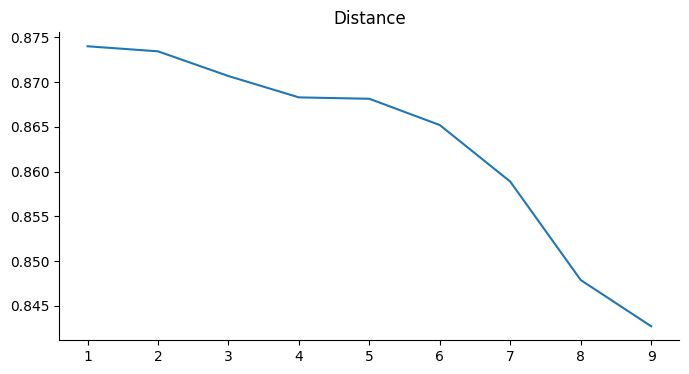

In [17]:
# @title Distance

from matplotlib import pyplot as plt
movie_recs['Distance'].plot(kind='line', figsize=(8, 4), title='Distance')
plt.gca().spines[['top', 'right']].set_visible(False)

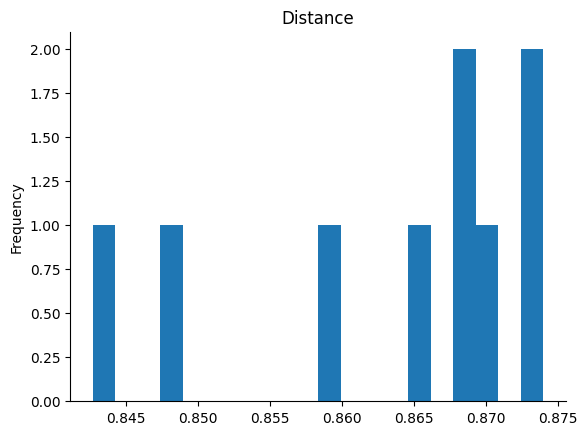

In [16]:
# @title Distance

from matplotlib import pyplot as plt
movie_recs['Distance'].plot(kind='hist', bins=20, title='Distance')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
movie_recs